Eigentliche gute Vorhersage.
Jetzt mehr backcandles ausprobieren, hyperparamter anapassen. inputs wo 150 ist. möglichkeit weitere indikatoren oder wie auch immer.

PROBLEM: Warum das Modell einen Denkfehler hat: Das Modell lernt, dass der aktuelle closingprice nicht all zu weit vom nächsten closingpreis entfernt seien wird. Jeder vorhergesagte Wert der nah am Closingpreis des vorherigen Tages ist, sieht aus als sei er genau.
Es sieht gut aus aber man kann erkennen, dass vorhersage nur 1 Tag verzögerter tatsächlicher Wert ist.
Modell versucht Closing Preis des nächsten Tages vorherzusagen anhand vergangener Daten. Das wird für jeden Tag getestet und soll zukpünftige Werte vorherzusagen

Neuer Ansatz. Target ist der Unterschied zwischen Close der aktuellen Kerze zur nächsten Close Kerze. Es wird nun statt dem Closepreis des nächsten Tages vorherzusagen, versucht um wie viel der preis hoch oder runter geht. Wo ist der Unterschied? Nächster candle Price vs Preisbewegung.

In [1]:
# Importieren der Bibliotheken
import mlflow
import mlflow.keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import ta



In [2]:

# Setzen des MLflow Tracking URI
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("Bitcoin Price Movement Prediction LSTM")

2024/05/30 14:02:50 INFO mlflow.tracking.fluent: Experiment with name 'Bitcoin Price Movement Prediction LSTM' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///C:/WWI2021/Semester 6/Machine Learning Project/mlruns/1', creation_time=1717070570447, experiment_id='1', last_update_time=1717070570447, lifecycle_stage='active', name='Bitcoin Price Movement Prediction LSTM', tags={}>

In [3]:
#.\venv\Scripts\activate

In [4]:
data = pd.read_csv("C:\WWI2021\Semester 6\Machine Learning Project\LSTM_BTC\data\BTC-USD.csv")
#data

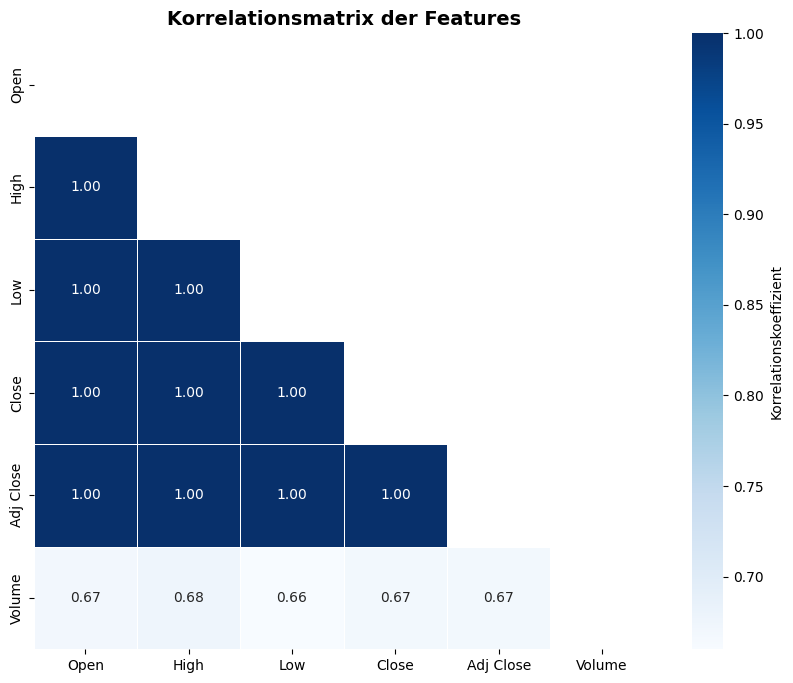

In [5]:
# Berechnen der Korrelationsmatrix
corr = data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='Blues', mask=mask, cbar_kws={'label': 'Korrelationskoeffizient'},
            linewidths=0.5, linecolor='white')
plt.title('Korrelationsmatrix der Features', fontsize=14, fontweight='bold')
plt.show()

In [6]:
data['RSI'] = ta.momentum.RSIIndicator(data['Close']).rsi()
data['EMA20'] = ta.trend.EMAIndicator(data['Close'], window=20).ema_indicator()
data['EMA100'] = ta.trend.EMAIndicator(data['Close'], window=100).ema_indicator()
data['EMA150'] = ta.trend.EMAIndicator(data['Close'], window=150).ema_indicator()


In [7]:
# Simple Moving Average (SMA)
data['SMA50'] = ta.trend.SMAIndicator(close=data['Close'], window=50).sma_indicator()
# Momentum Indicator
data['Momentum'] = ta.momentum.ROCIndicator(close=data['Close'], window=10).roc()
# Rate of Change (ROC)
data['ROC'] = ta.momentum.ROCIndicator(close=data['Close'], window=12).roc()
# Bollinger Bands
bollinger = ta.volatility.BollingerBands(close=data['Close'], window=20, window_dev=2)
data['Bollinger_Middle'] = bollinger.bollinger_mavg()
data['Bollinger_Upper'] = bollinger.bollinger_hband()
data['Bollinger_Lower'] = bollinger.bollinger_lband()
# Moving Average Convergence Divergence (MACD)
macd = ta.trend.MACD(close=data['Close'], window_slow=26, window_fast=12, window_sign=9)
data['MACD'] = macd.macd()


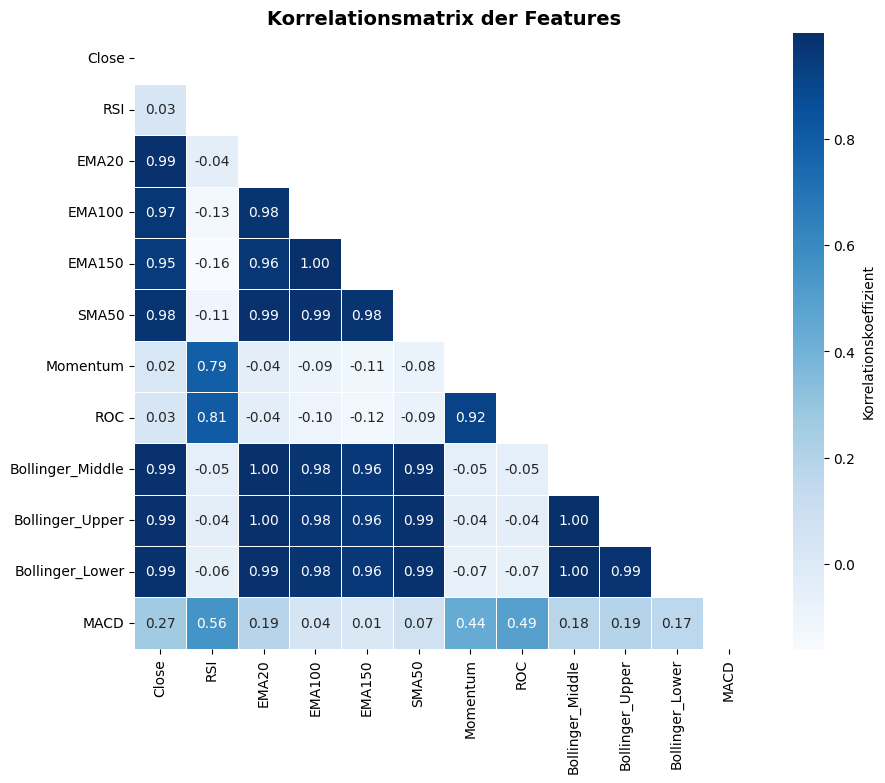

In [8]:
# Berechnen der Korrelationsmatrix
corr = data[['Close', 'RSI', 'EMA20', 'EMA100', 'EMA150', 'SMA50', 'Momentum', 'ROC', 'Bollinger_Middle', 'Bollinger_Upper', 'Bollinger_Lower', 'MACD']].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='Blues', mask=mask, cbar_kws={'label': 'Korrelationskoeffizient'},
            linewidths=0.5, linecolor='white')
plt.title('Korrelationsmatrix der Features', fontsize=14, fontweight='bold')
plt.show()

Feature Auswahl für das Modell
Aufgrund der hohen Korrelation und der Multikollinearität macht es Sinn, redundante Features zu eliminieren und nur repräsentative Features zu behalten. Hier ist eine mögliche Auswahl:

EMA20 oder SMA50: Behalte nur eines dieser Features, da beide stark miteinander und mit dem Ziel korrelieren. Zum Beispiel: EMA20.
Bollinger_Middle: Da es stark korreliert ist und repräsentativ für die Bollinger-Bänder ist, könnte man Bollinger_Middle anstelle von Upper und Lower behalten.
MACD: Trotz der negativen Korrelation kann MACD hilfreich sein, da es eine andere Dimension der Preisbewegung darstellt.
RSI: Obwohl die Korrelation gering ist, bietet RSI ein anderes Signal, das das Modell möglicherweise ergänzt.

In [9]:
data.drop(['Date','High', 'Low', 'Adj Close', 'Volume','Open', 'EMA100', 'EMA150', 'SMA50', 'Momentum', 'ROC', 'Bollinger_Upper', 'Bollinger_Lower'], axis=1, inplace=True)
data['Previous_Close'] = data['Close'].shift(1)
data.dropna(inplace=True)

In [10]:
# Zielvariablen für die Vorhersage erstellen
data['Target'] = (data['Close'] <= data['Previous_Close']).astype(int)

data_clean = data
data_clean.dropna(inplace=True)
data_clean.reset_index(drop=True, inplace=True)

In [11]:
from sklearn.preprocessing import MinMaxScaler

# Auswahl und Skalierung der relevanten Features
selected_features = ['Close', 'RSI', 'EMA20', 'Bollinger_Middle', 'MACD', 'Previous_Close']
sc = MinMaxScaler(feature_range=(0, 1))
scaled_features = sc.fit_transform(data[selected_features])

SEQ_LENGTH = 10 # Kann angepasst werden

def create_sequences(features, target, seq_length):
    sequences = []
    labels = []
    for i in range(len(features) - seq_length):
        sequence = features[i:i + seq_length]
        label = target[i + seq_length]
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), np.array(labels)

X, y = create_sequences(scaled_features, data['Target'].values, SEQ_LENGTH)


In [12]:
# Datenaufteilung: 70% Training, 20% Validierung, 10% Test
train_size = int(0.7 * len(X))
val_size = int(0.2 * len(X))
test_size = len(X) - train_size - val_size

X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

# Reshape für 1D-CNN und LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

Hyperparameter-Definition und Modelltraining

Epoch 1/50


c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5122 - loss: 243.0869 - val_accuracy: 0.4864 - val_loss: 0.7021
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5491 - loss: 0.6897 - val_accuracy: 0.5136 - val_loss: 0.6930
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5189 - loss: 0.6920 - val_accuracy: 0.4864 - val_loss: 0.7167
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5424 - loss: 0.6928 - val_accuracy: 0.4864 - val_loss: 0.7134
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5164 - loss: 0.6961 - val_accuracy: 0.4864 - val_loss: 0.7190
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5306 - loss: 0.6968 - val_accuracy: 0.4706 - val_loss: 0.6935
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5359 - loss: 0.6921 - val_accuracy: 0.4864 - val_loss: 0.7043
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5514 - loss: 0.6888 - val_accuracy: 0.4864 - val_loss: 0.7005
E

2024/05/30 14:03:06 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6934133768081665
Test Accuracy: 0.5171428322792053
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step

c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Confusion Matrix
[[181   0]
 [169   0]]
Classification Report
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       181
           1       0.00      0.00      0.00       169

    accuracy                           0.52       350
   macro avg       0.26      0.50      0.34       350
weighted avg       0.27      0.52      0.35       350



c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

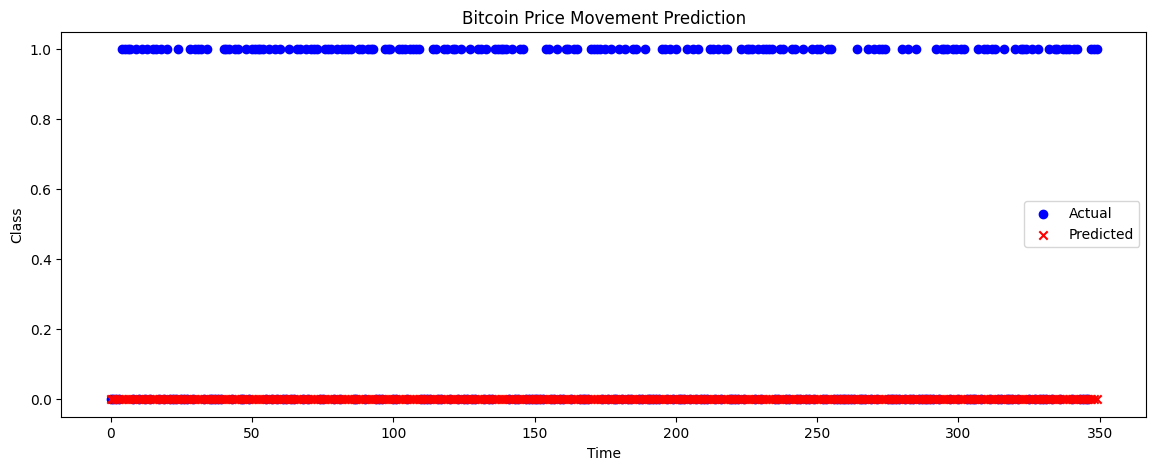

c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5332 - loss: 0.6914 - val_accuracy: 0.4864 - val_loss: 0.6981
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5360 - loss: 0.6900 - val_accuracy: 0.4864 - val_loss: 0.7009
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5238 - loss: 0.6943 - val_accuracy: 0.4864 - val_loss: 0.7000
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5312 - loss: 0.6919 - val_accuracy: 0.4864 - val_loss: 0.7012
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5513 - loss: 0.6878 - val_accuracy: 0.4864 - val_loss: 0.6965
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5390 - loss: 0.6890 - val_accuracy: 0.4864 - val_loss: 0.6963
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5580 - loss: 0.6863 - val_accuracy: 0.4864 - val_loss: 0.6985
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5539 - loss: 0.6874 - val_accuracy: 0.4864 - val_loss:

2024/05/30 14:03:26 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6942790746688843
Test Accuracy: 0.5171428322792053
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Confusion Matrix
[[181   0]
 [169   0]]
Classification Report
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       181
           1       0.00      0.00      0.00       169

    accuracy                           0.52       350
   macro avg       0.26      0.50      0.34       350
weighted avg       0.27      0.52      0.35       350



c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

<Figure size 640x480 with 0 Axes>

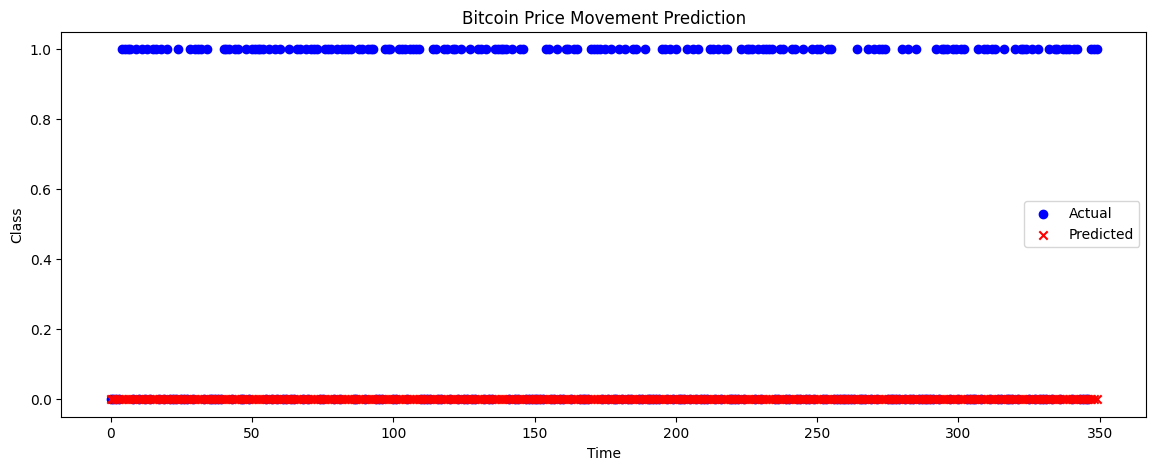

Epoch 1/50


c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5576 - loss: 0.6888 - val_accuracy: 0.4864 - val_loss: 0.7007
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5503 - loss: 0.6878 - val_accuracy: 0.4864 - val_loss: 0.6946
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5535 - loss: 0.6877 - val_accuracy: 0.4864 - val_loss: 0.6947
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5448 - loss: 0.6880 - val_accuracy: 0.4864 - val_loss: 0.6948
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5514 - loss: 0.6870 - val_accuracy: 0.4864 - val_loss: 0.6943
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5362 - loss: 0.6888 - val_accuracy: 0.4864 - val_loss: 0.6954
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5545 - loss: 0.6845 - val_accuracy: 0.4921 - val_loss: 0.6939
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5479 - loss: 0.6866 - val_accuracy: 0.4921 - val_loss: 0.6941
Epo

2024/05/30 14:03:44 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6941844820976257
Test Accuracy: 0.47999998927116394
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Confusion Matrix
[[102  79]
 [103  66]]
Classification Report
              precision    recall  f1-score   support

           0       0.50      0.56      0.53       181
           1       0.46      0.39      0.42       169

    accuracy                           0.48       350
   macro avg       0.48      0.48      0.47       350
weighted avg       0.48      0.48      0.48       350



<Figure size 640x480 with 0 Axes>

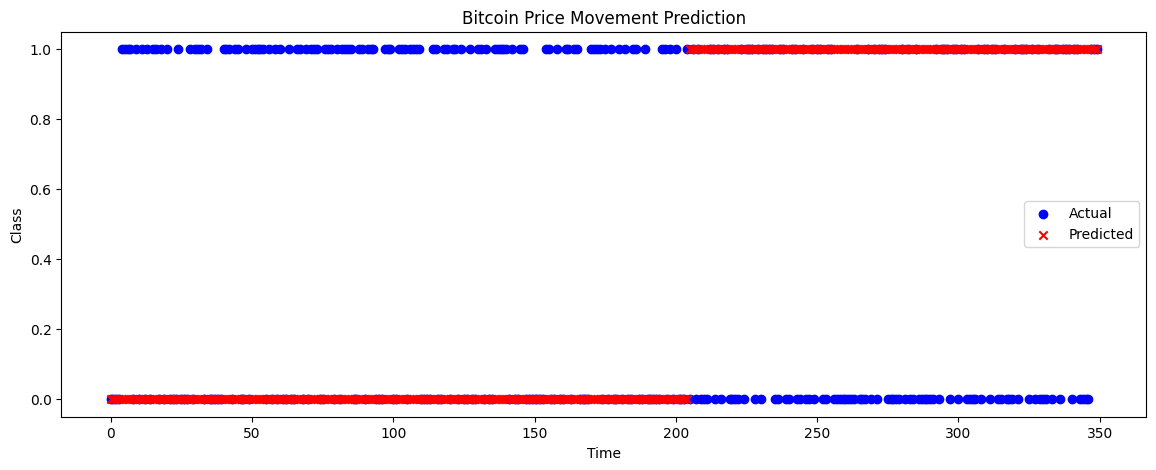

Epoch 1/50


c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4710 - loss: 0.6942 - val_accuracy: 0.4749 - val_loss: 0.6934
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5485 - loss: 0.6922 - val_accuracy: 0.4792 - val_loss: 0.6940
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5415 - loss: 0.6915 - val_accuracy: 0.4878 - val_loss: 0.6945
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5439 - loss: 0.6905 - val_accuracy: 0.4864 - val_loss: 0.6952
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5446 - loss: 0.6895 - val_accuracy: 0.4864 - val_loss: 0.6961
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5466 - loss: 0.6893 - val_accuracy: 0.4864 - val_loss: 0.6965
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5336 - loss: 0.6909 - val_accuracy: 0.4864 - val_loss: 0.6965
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5444 - loss: 0.6894 - val_accuracy: 0.4864 - val_loss: 0.6968
Epo

2024/05/30 14:04:02 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6941969990730286
Test Accuracy: 0.4942857027053833
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Confusion Matrix
[[99 82]
 [95 74]]
Classification Report
              precision    recall  f1-score   support

           0       0.51      0.55      0.53       181
           1       0.47      0.44      0.46       169

    accuracy                           0.49       350
   macro avg       0.49      0.49      0.49       350
weighted avg       0.49      0.49      0.49       350



<Figure size 640x480 with 0 Axes>

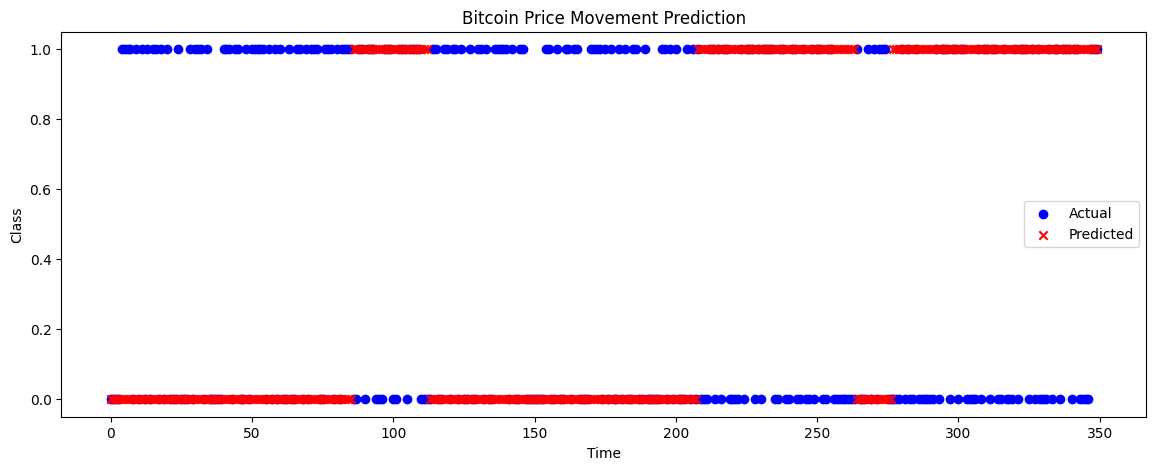

<Figure size 640x480 with 0 Axes>

In [13]:
# Hyperparameter und Modelltraining
learning_rates = [0.1, 0.01, 0.001, 0.0001]

for lr in learning_rates:
    with mlflow.start_run():
        params = {"learning_rate": lr, "epochs": 50, "batch_size": 32, "seq_length": SEQ_LENGTH}
        mlflow.log_params(params)

        optimizer = Adam(learning_rate=lr)

        # Modellarchitektur definieren
        model = Sequential()
        model.add(LSTM(units=50, activation='relu', input_shape=(SEQ_LENGTH, len(selected_features)), return_sequences=True))
        model.add(LSTM(units=50, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(units=1, activation='sigmoid'))

        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

        # Modell trainieren
        history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

        # Modell bewerten
        loss, accuracy = model.evaluate(X_test, y_test)
        print(f'Test Loss: {loss}')
        print(f'Test Accuracy: {accuracy}')

        # MLflow-Logging
        mlflow.log_metric("loss", loss)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.keras.log_model(model, "model")

        # Vorhersagen treffen und Wahrscheinlichkeiten in binäre Werte umwandeln
        predictions = (model.predict(X_test) > 0.5).astype(int)

        # Confusion Matrix
        cm = confusion_matrix(y_test, predictions)
        print('Confusion Matrix')
        print(cm)

        # Classification Report
        cr = classification_report(y_test, predictions)
        print('Classification Report')
        print(cr)

        # Plot der Ergebnisse
        plt.figure(figsize=(14, 5))
        plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual', marker='o')
        plt.scatter(range(len(predictions)), predictions, color='red', label='Predicted', marker='x')
        plt.title('Bitcoin Price Movement Prediction')
        plt.xlabel('Time')
        plt.ylabel('Class')
        plt.legend()
        plt.show()


        # Log confusion matrix and classification report
        with open("confusion_matrix_lstm.txt", "w") as f:
            f.write(str(cm))
        mlflow.log_artifact("confusion_matrix_lstm.txt")

        with open("classification_report_lstm.txt", "w") as f:
            f.write(cr)
        mlflow.log_artifact("classification_report_lstm.txt")

        # Set a tag for the run
        mlflow.set_tag("model", "LSTM")


In [14]:
# Vorhersagen treffen
predictions = (model.predict(X_test) > 0.5).astype(int)

# Modell bewerten
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')



11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4986 - loss: 0.6941 
Test Loss: 0.6941969990730286
Test Accuracy: 0.4942857027053833


In [16]:
# Modell bewerten
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# MLflow-Logging
mlflow.log_metric("loss", loss)
mlflow.log_metric("accuracy", accuracy)
mlflow.keras.log_model(model, "model")


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4986 - loss: 0.6941 


2024/05/30 14:04:06 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6941969990730286
Test Accuracy: 0.4942857027053833


Confusion Matrix
[[99 82]
 [95 74]]
Classification Report
              precision    recall  f1-score   support

           0       0.51      0.55      0.53       181
           1       0.47      0.44      0.46       169

    accuracy                           0.49       350
   macro avg       0.49      0.49      0.49       350
weighted avg       0.49      0.49      0.49       350



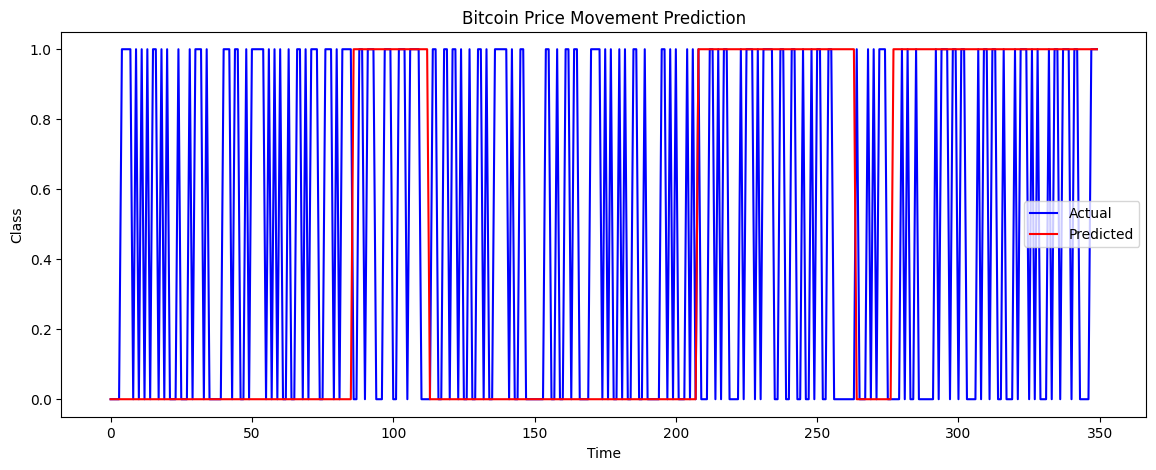

In [17]:
# Ergebnisse visualisieren
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Confusion Matrix
cm = confusion_matrix(y_test, predictions)
print('Confusion Matrix')
print(cm)

# Classification Report
cr = classification_report(y_test, predictions)
print('Classification Report')
print(cr)

# Plot der Ergebnisse
plt.figure(figsize=(14, 5))
plt.plot(y_test, color='blue', label='Actual')
plt.plot(predictions, color='red', label='Predicted')
plt.title('Bitcoin Price Movement Prediction')
plt.xlabel('Time')
plt.ylabel('Class')
plt.legend()
plt.show()

Confusion Matrix
[[99 82]
 [95 74]]
Classification Report
              precision    recall  f1-score   support

           0       0.51      0.55      0.53       181
           1       0.47      0.44      0.46       169

    accuracy                           0.49       350
   macro avg       0.49      0.49      0.49       350
weighted avg       0.49      0.49      0.49       350



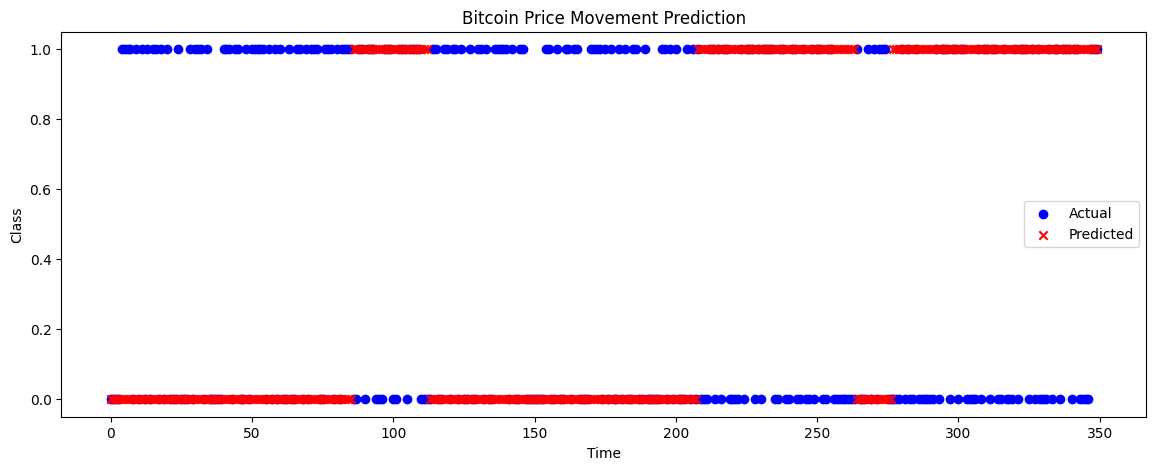

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Confusion Matrix
cm = confusion_matrix(y_test, predictions)
print('Confusion Matrix')
print(cm)

# Classification Report
cr = classification_report(y_test, predictions)
print('Classification Report')
print(cr)

# Plot der Ergebnisse
plt.figure(figsize=(14, 5))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual', marker='o')
plt.scatter(range(len(predictions)), predictions, color='red', label='Predicted', marker='x')
plt.title('Bitcoin Price Movement Prediction')
plt.xlabel('Time')
plt.ylabel('Class')
plt.legend()
plt.show()


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


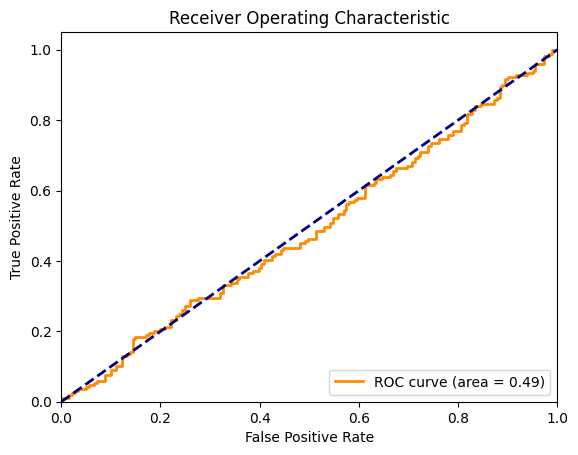

In [19]:
from sklearn.metrics import roc_curve, auc

y_pred_prob = model.predict(X_test).ravel()
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


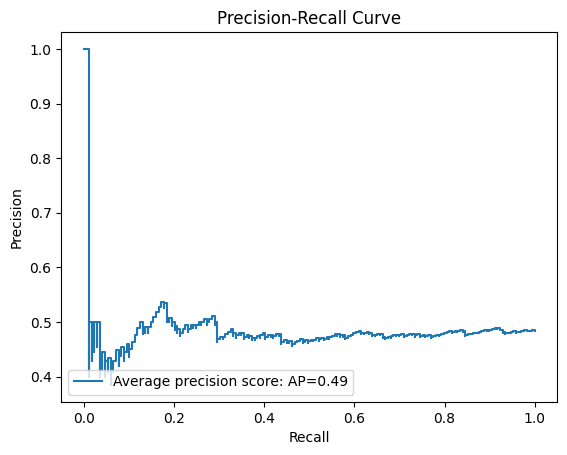

In [20]:
from sklearn.metrics import precision_recall_curve, average_precision_score

y_pred_prob = model.predict(X_test).ravel()
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
average_precision = average_precision_score(y_test, y_pred_prob)

plt.figure()
plt.step(recall, precision, where='post', label='Average precision score: AP={0:0.2f}'.format(average_precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


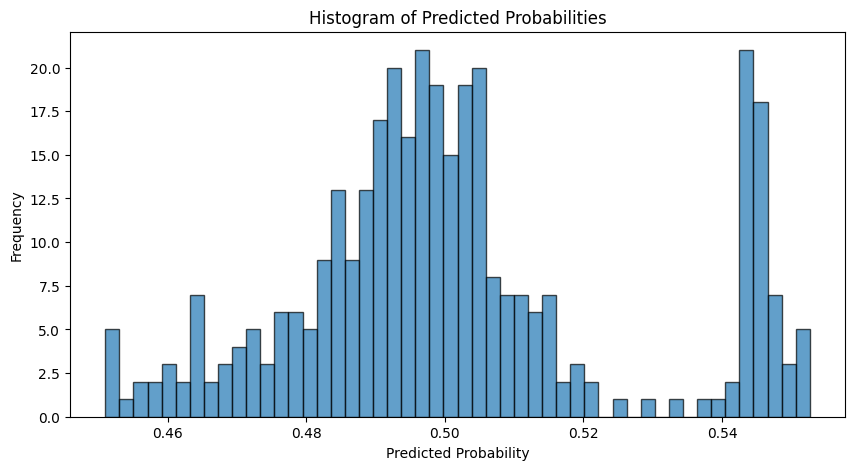

In [21]:
y_pred_prob = model.predict(X_test).ravel()

plt.figure(figsize=(10, 5))
plt.hist(y_pred_prob, bins=50, edgecolor='k', alpha=0.7)
plt.title('Histogram of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()


Optimierungsmöglichkeiten für wenn Lifecycle Management Tool eingeführt ist:

Wenn Sie die Preisbewegung (zum Beispiel die Richtung der Preisänderung oder die prozentuale Änderung) anstelle des tatsächlichen Preises vorhersagen und feststellen, dass die Leistung des Modells nicht zufriedenstellend ist, gibt es mehrere Ansätze, um die Vorhersagequalität zu verbessern. Hier sind einige Strategien, die Sie in Betracht ziehen können:


### 2. **Modellarchitektur anpassen**
- **Anzahl der LSTM-Einheiten ändern**: Erhöhen oder verringern Sie die Anzahl der Neuronen in den LSTM-Schichten, um zu sehen, ob dies die Modellleistung beeinflusst.
- **Tiefe des Netzwerks**: Fügen Sie mehrere LSTM-Schichten hinzu, um ein tieferes Netzwerk zu erstellen, das möglicherweise komplexere Muster erfassen kann.
- **Dropout hinzufügen**: Um Overfitting zu vermeiden, fügen Sie Dropout-Schichten hinzu, die helfen können, die Generalisierbarkeit des Modells zu verbessern.

### 3. **Hyperparameter optimieren**
- **Lernrate anpassen**: Experimentieren Sie mit unterschiedlichen Lernraten und anderen Optimierungsparametern.
- **Batch-Größe und Epochenzahl**: Das Ändern der Batch-Größe und der Anzahl der Epochen kann erhebliche Auswirkungen auf das Trainingsergebnis haben.
- **Regularisierung anwenden**: Experimentieren Sie mit verschiedenen Arten von Regularisierungen (L1, L2), um das Overfitting zu kontrollieren.

### 4. **Verlustfunktion anpassen**
- **Andere Verlustfunktionen ausprobieren**: Wenn Sie die Richtung der Preisbewegung vorhersagen, könnte eine binäre Kreuzentropie (wenn es sich um eine Klassifikationsaufgabe handelt) oder eine benutzerdefinierte Verlustfunktion, die speziell für Ihr Vorhersageziel entwickelt wurde, nützlich sein.

### 5. **Trainingstechniken überprüfen**
- **Frühzeitiges Beenden**: Verwenden Sie Early Stopping, um das Training zu beenden, wenn sich die Validierungsleistung nicht mehr verbessert.
- **Daten-Shuffling und -Partitionierung**: Stellen Sie sicher, dass Ihre Trainings-, Validierungs- und Testdatensätze richtig partitioniert und während des Trainings effektiv gemischt werden.

### 6. **Evaluation und Benchmarking**
- **Cross-Validation verwenden**: Statt einer einfachen Train-Test-Split kann Cross-Validation eine robustere Evaluation der Modellleistung bieten.
- **Leistungsmetriken**: Überprüfen Sie, ob Sie die richtigen Metriken für die Bewertung des Modells verwenden. Für Klassifikationsaufgaben sind Genauigkeit, F1-Score, ROC-AUC usw. relevant.

Diese Ansätze bieten verschiedene Wege, die Modellleistung zu verbessern und sollten je nach spezifischem Szenario und den Ergebnissen der initialen Modellbewertungen angepasst werden.